# Clasificación de Células Sanguíneas

En el proceso de diagnóstico de enfermedades, el estudio de la cantidad de células sanguíneas juega un papel importante para determinar factores que explican una enfermedad. En esta tarea, la idea es implementar el modelo de deep-learning más efectivo posible para clasificar células sanguíneas. Las clases de células sanguíneas son: [Eosinophil, Lymphocyte, Monocyte, Neutrophil]


In [ ]:
# Para correr en Google Colab
!rm -rf CC6204-Deep-Learning-T3
!git clone https://github.com/M4thinking/CC6204-Deep-Learning-T3.git/
# Accedemos al directorio del repositorio desde la consola
!cd CC6204-Deep-Learning-T3/
# Instalamos el paquete gdown para poder descargar el dataset desde el gdrive
!pip install gdown

In [1]:
#Descargamos el dataset
import gdown
output = 'blood.zip'
gdown.download(id='1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3', output=output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3
To: g:\Mi unidad\Primavera2022\CC6204-Deep-Learning-T3\blood.zip
100%|██████████| 105M/105M [00:01<00:00, 58.0MB/s] 


'blood.zip'

In [ ]:
## Para correr en Google Colab
# Descomprimimos el dataset
!unzip blood.zip -d CC6204-Deep-Learning-T3/
# Paquete para visualizacion en tiempo real de entrenmiento
!pip install livelossplot
# Cambiamos el ambiente del notebook de trabajo
%cd CC6204-Deep-Learning-T3/

Implementa la mejor red neuronal posible. Tú decides si usas una red creada por ti mismo o si empleas transfer-learning. Entrena la red con los datos en la carpeta "TRAIN" y usa los datos en "VAL" como validación.

Para medir el performance final, realiza las inferencias sobre los datos del conjunto "TEST" y computa el accuracy sobre el conjunto de test. El accuracy es la proporción de imágenes para las cuales la predicción es correcta. IMPORTANTE: el accuracy de test se calcula una sola vez cuando hayas finalizado todos tus experimentos. Para tomar decisiones sobre el modelo y sus hiperparámetros solo puedes usar el conjunto de entrenamiento y validación.

Detalla todos los experimentos que hiciste y cómo llegaste a la mejor red neuronal reportada. Discute los resultados, comparando los distintos experimentos que tomaste en cuenta y responde a la pregunta: Porqué tu modelo final fue el mejor de todo lo que probaste?

IMPORTANTE: Evita el overfitting a toda costa. Un modelo con overfitting es aquel que durante el entrenamiento las curvas de loss/accuracy para datos de entrenamiento y validación se separan considerablemente. 

Éxitos!

In [2]:
import os
import sys
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from livelossplot import PlotLosses

# Pythorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchsummary import summary

## Exploración de los datos

Para poder construir un modelo que haga la clasificación, primero es necesario realizar un análisis exploratorio de los datos.

In [3]:
# Abrimos una imagen de cada carpeta de celulas
import cv2

# Semilla para reproducibilidad
def iniciar_semillas():
  SEED = 1234
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True

def showimage(myimage):
    if (myimage.ndim>2):  #This only applies to RGB or RGBA images (e.g. not to Black and White images)
        myimage = myimage[:,:,::-1] #OpenCV follows BGR order, while matplotlib likely follows RGB order
         
    fig, ax = plt.subplots(figsize=[10,10])
    ax.imshow(myimage, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.show()

def preprocess_data(data = "TRAIN", visualize = True, apply_mask = True):
    root = "images/"+data+"/"
    white_blood_cells = ["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]
    size_folder = [len(os.listdir(root+white_blood_cells[i])) for i in range(len(white_blood_cells))]
    print(f"Cantidad de datos por clase en {data}:", size_folder)
    # Calcular media y desviación estandar del conjunto de imagenes por canal
    mean = np.zeros(3)
    std = np.zeros(3)
    nb_samples = 0.
    for i in range(len(white_blood_cells)):
        for filename in os.listdir(root+white_blood_cells[i]):
            img = plt.imread(root+white_blood_cells[i]+"/"+filename)
            if apply_mask:
                img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                lower_blue = np.array([100, 50, 50])
                upper_blue = np.array([180, 255, 255])
                # InRange para mascara
                mask = cv2.inRange(img_hsv, lower_blue, upper_blue)
                mask[mask==255] = 1
                # Mascara de 3 canales
                mask = np.stack((mask, mask, mask), axis=2)
                # Aplicar mascara a cada canal
                img = img * mask
            img = img/255
            # shape (height, width, channels)
            nb_samples += 1
            for j in range(3):
                mean[j] += img[:, :, j].mean()
                std[j] += img[:, :, j].std()
                
    mean /= nb_samples
    std /= nb_samples
    print(f"\nMedia de {data} por canal: {mean}")
    print(f"Desviación estandar de {data} por canal: {std}\n")
    transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((240, 320)),
    transforms.Normalize(mean=mean, std=std)
    ])
    if visualize:
        # Visualizar imagenes
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        for i in range(2):
            for j in range(2):
                img = plt.imread(root+white_blood_cells[i*2+j]+"/"+os.listdir(root+white_blood_cells[i*2+j])[0])
                ax[i, j].imshow(img)
                ax[i, j].set_title(white_blood_cells[i*2+j])
                ax[i, j].axis('off')
        # Big title
        fig.suptitle(f"Imágenes de {data}", fontsize=16)
        plt.show()

        # Análisis de histograma por canal y por clase
        fig, ax = plt.subplots(2, 2, figsize=(10, 10))
        for i in range(2):
            for j in range(2):
                img = plt.imread(root+white_blood_cells[i*2+j]+"/"+os.listdir(root+white_blood_cells[i*2+j])[0])
                ax[i, j].hist(img[:,:,0].flatten(), bins=50, color='r', alpha=0.5)
                ax[i, j].hist(img[:,:,1].flatten(), bins=50, color='g', alpha=0.5)
                ax[i, j].hist(img[:,:,2].flatten(), bins=50, color='b', alpha=0.5)
                ax[i, j].set_title(white_blood_cells[i*2+j])
        # Big title
        fig.suptitle("Histograma de imagenes por canal y por clase", fontsize=16)
        plt.show()

        if apply_mask:
            # Aplicando un umbral por cada canal
            fig, ax = plt.subplots(2, 2, figsize=(10, 10))
            for i in range(2):
                for j in range(2):
                    img = plt.imread(root+white_blood_cells[i*2+j]+"/"+os.listdir(root+white_blood_cells[i*2+j])[0])
                    # Imagen de RGB a HSV
                    # img = transform(img)
                    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                    lower_blue = np.array([100, 50, 50])
                    upper_blue = np.array([180, 255, 255])
                    # InRange para mascara
                    mask = cv2.inRange(img_hsv, lower_blue, upper_blue)
                    mask[mask==255] = 1
                    # Mascara de 3 canales
                    mask = np.stack((mask, mask, mask), axis=2)
                    # Aplicar mascara a cada canal
                    img_mask = img * mask
                    ax[i, j].imshow(img_mask)
                    ax[i, j].set_title(white_blood_cells[i*2+j])
                    ax[i, j].axis('off')
            # Big title
            fig.suptitle("Imagenes por canal y por clase con umbral", fontsize=16)
            plt.show()

        # Dimensiones de las imagenes
        print("\nDimensiones de las imagenes", img.shape)
        img = plt.imread(root+white_blood_cells[0]+"/"+os.listdir(root+white_blood_cells[0])[0])
    return mean, std


Cantidad de datos por clase en TRAIN: [2497, 2483, 2478, 2499]

Media de TRAIN por canal: [0.0390093  0.03131173 0.05123866]
Desviación estandar de TRAIN por canal: [0.14901354 0.12089108 0.19583434]



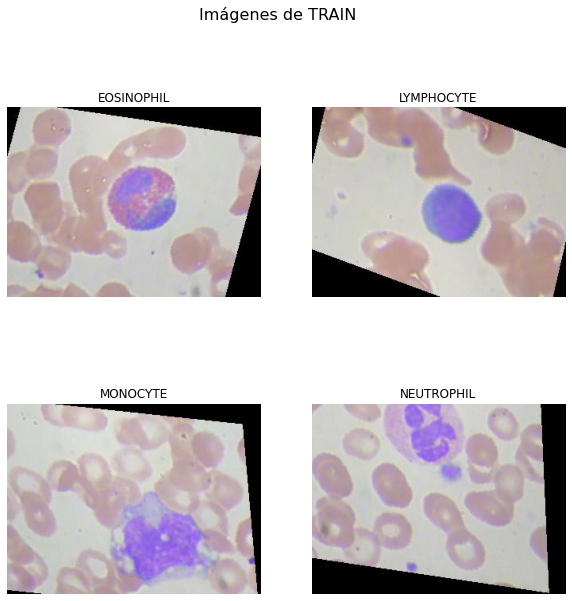

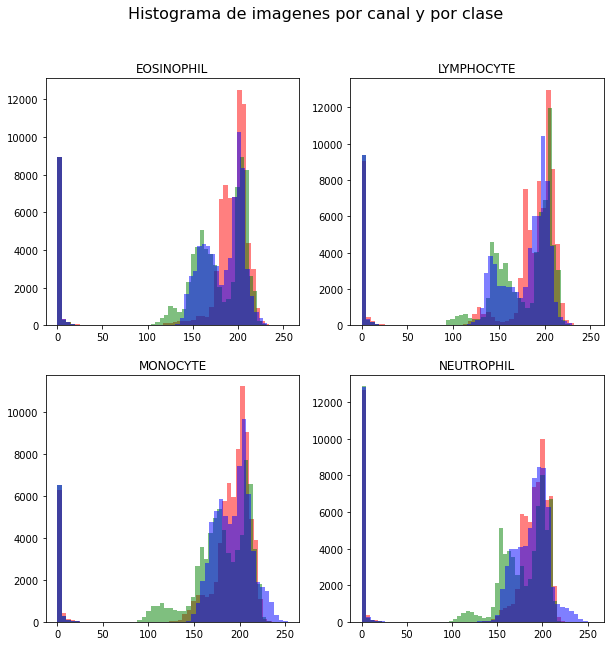

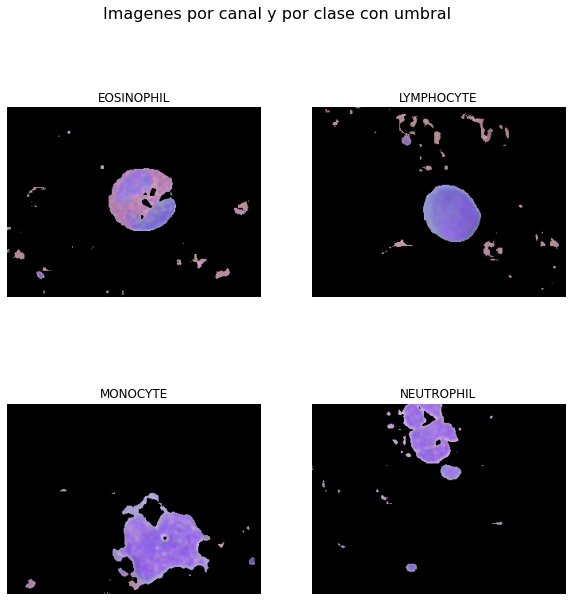


Dimensiones de las imagenes (240, 320, 3)


In [4]:
train_mean, train_std = preprocess_data("TRAIN")

Cantidad de datos por clase en VAL: [13, 6, 4, 48]

Media de VAL por canal: [0.03863134 0.03061332 0.04975875]
Desviación estandar de VAL por canal: [0.15044293 0.12061238 0.19327031]



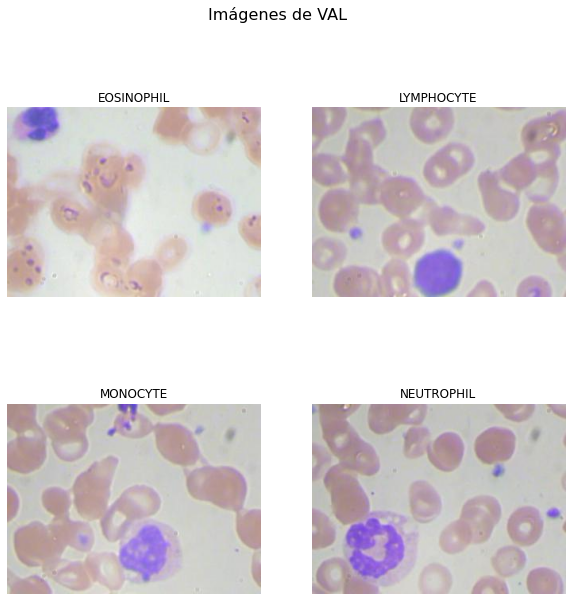

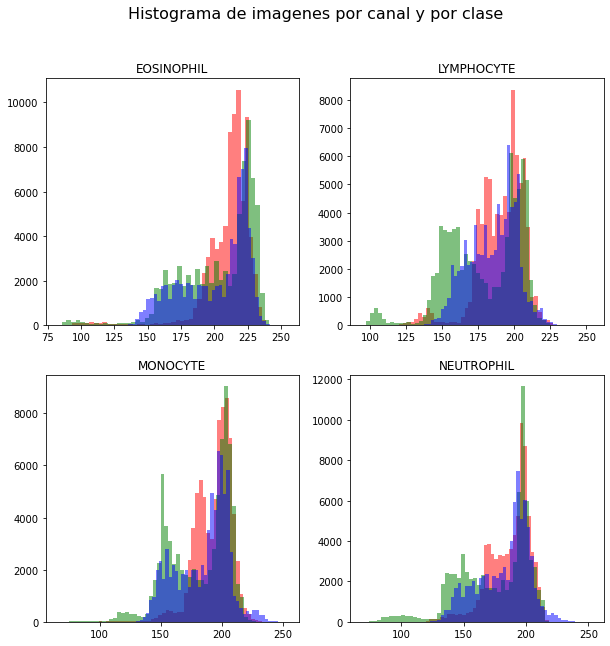

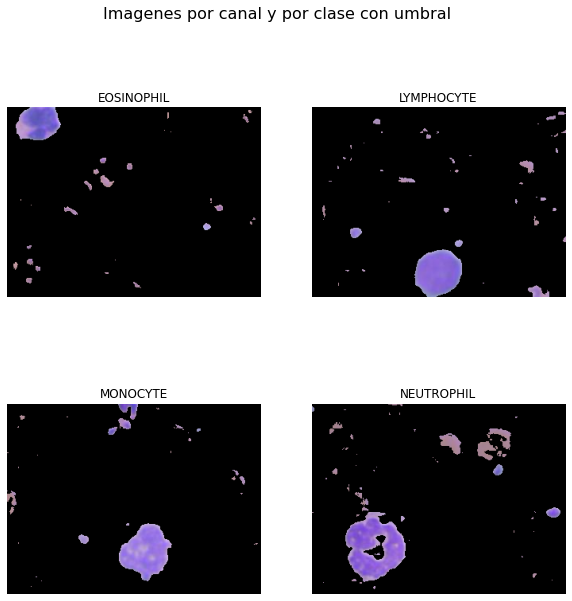


Dimensiones de las imagenes (240, 320, 3)


In [5]:
val_mean, val_std = preprocess_data("VAL")

## Clases ConvNet y BloodDataset

In [49]:
# Se crear modelo de red neuronal convolucional para clasificar las celulas
class ConvNet(nn.Module):
    # Dato de entrada: imagen de 3 canales (RGB) de 240x320
    # Dato de salida: 4 clases (EOSINOPHIL, LYMPHOCYTE, MONOCYTE, NEUTROPHIL)
    def __init__(
        self,
        act=nn.ReLU(),
        dropout = 0.5,
        conv = [8, 16, 32],
    ):
        super().__init__()
        # Inicializacion de Kaiming He
        self.init = nn.init.kaiming_normal_
        # Convolutional layers with LongTensor type
        self.conv1 = nn.Conv2d(3        , conv[0],  3,  padding=1)
        self.conv2 = nn.Conv2d(conv[0]  , conv[1],  3,  padding=1)
        self.conv3 = nn.Conv2d(conv[1]  , conv[2],  3,  padding=1)
        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(conv[0])
        self.bn2 = nn.BatchNorm2d(conv[1])
        self.bn3 = nn.BatchNorm2d(conv[2])
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Average pooling layer of 30x40
        self.avgpool = nn.AvgPool2d((30, 40))
        # Fully connected layers
        self.fc1 = nn.Linear(conv[2], conv[1])
        self.fc2 = nn.Linear(conv[1], 4)
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        # Activation function from nn
        self.act_fun = act
        # Convolutional layers arquitecture
        self.conv_arquitecture = conv
     

    def forward(self, x):
        x = x.float()
        # Add sequence of convolutional + activation function + max pooling + batch norm layers
        x = self.bn1(self.pool(self.act_fun(self.conv1(x))))
        x = self.bn2(self.pool(self.act_fun(self.conv2(x))))
        x = self.bn3(self.pool(self.act_fun(self.conv3(x))))
        # Average pooling layer
        x = self.avgpool(x)
        # Flatten image input
        x = x.view(-1, 32)
        # Add dropout layer
        x = self.dropout(x)
        # Add 1st hidden layer, with activation function
        x = self.act(self.fc1(x))
        # Add dropout layer
        x = self.dropout(x)
        # Add 2nd hidden layer, with activation function
        x = self.fc2(x)
        return x

# Crear un dataset para cargar las imagenes en el modelo
class BloodDataset(Dataset):
    def __init__(self, data = "TRAIN", transform = None, mask = False):
        self.root = "images/"+data+"/"
        self.white_blood_cells = ["EOSINOPHIL", "LYMPHOCYTE", "MONOCYTE", "NEUTROPHIL"]
        self.transform = transform
        self.data = []
        self.mask = mask
        for label in range(len(self.white_blood_cells)):
            for image in os.listdir(self.root+self.white_blood_cells[label]):
                # Make a tensor with image and label
                self.data.append([image, label])
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx][0]
        label = self.data[idx][1]
        image = plt.imread(self.root+self.white_blood_cells[label]+"/"+image)
        
        if self.mask: 
            image = self.mask_transform(image)

        image = image/255
        if self.transform: 
            image = self.transform(image)
        return image, label
    
    def mask_transform(image):
        img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        lower_blue = np.array([100, 50, 50])
        upper_blue = np.array([180, 255, 255])
        # InRange para mascara
        mask = cv2.inRange(img_hsv, lower_blue, upper_blue)
        mask[mask==255] = 1
        # Mascara de 3 canales
        mask = np.stack((mask, mask, mask), axis=2)
        # Aplicar mascara a cada canal
        image = image * mask
        return image

## Funciones de entrenamiento, curvas de Loss/época - Accuracy/época

In [50]:
# Funcion para graficar la curva final de entrenamiento y validacion
def show_curves(model_path = "model_x"):
    curves = torch.load("models/"+model_path+"/curves.pt")
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()
    
    plt.savefig("models/"+model_path+"/acc-loss-curve.png")
    plt.show()

In [62]:
# Se crea un modelo de red neuronal convolucional
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)
    # Cálculo de loss con cross entropy
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    # Gradient clipping entre -1 y 1
    nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()

    return y_predicted, loss

# Se evalua el modelo
def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)
        
        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item()
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / len(val_loader)

    return val_acc, val_loss

# Funcion para entrenar el modelo
def train_model(
    model,
    model_path,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    optimizer,
    batch_size,
    n_evaluations_per_epoch=6,
    device = "cuda",
    data_augmentation=False,
    early_stopping = 8,
    gpu_frac = 0.9,
    scheduler = False
):
    use_gpu = False
    liveloss = PlotLosses()
    model.to(device)
    if device == "cuda":
        use_gpu = True
        torch.cuda.set_per_process_memory_fraction(gpu_frac)
    
    original_transform = train_dataset.transform

    if data_augmentation:
        train_dataset.transform = transforms.Compose([
            original_transform,
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
        ])

    else:
        train_dataset.transform = original_transform

    print(f"Using train transform: {train_dataset.transform}")
    print(f"Using validation transform: {val_dataset.transform}")


    # Definición de dataloader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=use_gpu)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False, pin_memory=use_gpu)

    # Dimensiones de los batch en cada data loaders
    print(f"Train loader batch size: {train_loader.batch_size}")
    print(f"Validation loader batch size: {val_loader.batch_size}")

    # Optimizador 
    optimizer = optimizer
    
    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    # Guardar metadata del modelo en un diccionario
    metadata = {
        "epochs": epochs,
        "batch_size": batch_size,
        "optimizer": optimizer,
        "criterion": criterion,
        "data_augmentation": data_augmentation,
        "early_stopping": early_stopping,
        "scheduler": scheduler,
        "train_transform": train_dataset.transform,
        "val_transform": val_dataset.transform,
        "mask": train_dataset.mask,
        "conv_architecture": model.conv_architecture,
        "activation_function": model.act_fun,
        "dropout": model.dropout,
        "criterion": criterion,
        "train_time": 0,
    }
    torch.save(metadata, "models/"+model_path+"/metadata.pt")

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)

    # Early stopping
    best_val_acc = 0
    best_val_count = 0
    
    for epoch in range(epochs):

        logs = {}
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0

        # Entrenamiento del modelo
        model.train()
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if device == "cuda":
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, device)

            cumulative_train_loss += loss.item()
            train_loss_count += 1
            train_acc_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()
            train_loss = 0
            train_acc = 0
            if (i % (n_batches // n_evaluations_per_epoch) == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count
                
            iteration += 1
            # Mostramos la iteracion actual
            print(f"\rIteration {iteration} - Batch {i+1}/{len(train_loader)}", end="")

        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, device)

            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_val_count = 0
                torch.save(model.state_dict(), "models/"+model_path+"/model.pt")
            else:
                best_val_count += 1

        print(f"\nVal loss: {val_loss}, Val acc: {val_acc}")

        # Guardamos curvas de entrenamiento y validación
        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        # Alimentar grafica en tiempo real
        logs['log loss'] = train_loss
        logs['accuracy'] = train_acc
        logs['val_log loss'] = val_loss
        logs['val_accuracy'] = val_acc
        
        liveloss.update(logs)
        liveloss.send()

        # Guardar las curvas en cada epoca en curvas.pt
        torch.save(curves, "models/"+model_path+"/curves.pt")
        # Actualizar el tiempo de entrenamiento
        metadata["train_time"] = time.perf_counter() - t0
        torch.save(metadata, "models/"+model_path+"/metadata.pt")
        if best_val_count == early_stopping:
            break

        scheduler.step()

    print()
    print("Tiempo total de entrenamiento: %.4f [s]" % metadata["train_time"])
    # Actualizar el tiempo de entrenamiento
    torch.save(metadata, "models/"+model_path+"/metadata.pt")
    # Graficar curvas  de entrenamiento y validación actualizando el mismo grafico con liveloss
    model.cpu()

    return curves

In [111]:
# Visualizar resultado del modelo con un ejemplo
def visualize_model(model_path, val_dataset, detail = False):
    # Cargar metadata
    metadata = torch.load("models/"+model_path+"/metadata.pt")

    # Cargar modelo
    model = ConvNet(
                    act=metadata["activation_function"],
                    dropout=metadata["dropout"],
                    conv_architecture=metadata["conv_architecture"]
            )

    model.load_state_dict(torch.load("models/"+model_path+"/model.pt"))

    # Mostrar la curva de entrenamiento y validación
    show_curves(model_path)

    if detail:
        # Resultado de accuracy y perdida desde carpeta
        curves = torch.load("models/"+model_path+"/curves.pt")

        # Valor final
        print("--- Final metrics ---\n")
        print(f"Final accuracy: {np.max(curves['val_acc'])}")
        print(f"Final loss: {np.max(curves['val_loss'])}\n")

        # Cargar arquitecura del modelo completo
        print("--- Summary ---\n")
        summary(model.cuda(), (3, 240, 320))
        model.cpu()

        # Métricas de evaluación
        with torch.no_grad():
            x, y = val_dataset[0]
            y_predicted = model(x.unsqueeze(0))
            class_prediction = torch.argmax(y_predicted, axis=1).long()
            print(f"Real class: {y}")
            print(f"Predicted class: {class_prediction}")

        # Printear todos los campos de la metadata
        print("--- Metadata ---\n")
        for key, value in metadata.items():
            print(f"{key}: {value}\n")

    return model, metadata["criterion"]

# Evaluar el modelo con el dataset de test
def evaluate_model(model, model_path, test_dataset, use_gpu = False, criterion = nn.CrossEntropyLoss()):
    model.eval()
    with torch.no_grad():
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
        test_acc, test_loss = evaluate(test_loader, model, criterion, use_gpu=False)
        print(f"Test loss: {test_loss}, Test acc: {test_acc}")

## Inicialización del modelo y entrenamiento

In [64]:
## Párametros de entrenamiento modificables

# Seed para reproducibilidad
iniciar_semillas()

# Funcion de activacion
activation = nn.ReLU()

# Crear un modelo de red neuronal convolucional
model = ConvNet(act=activation)

# Aplicar transformaciones a las imagenes
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((240, 320)),
    transforms.Normalize(mean=train_mean, std=train_std),
])

# Crear un dataset de entrenamiento, validacion y test
train_dataset = BloodDataset(data = "TRAIN", transform = transform)
val_dataset = BloodDataset(data = "VAL", transform = transform)
test_dataset = BloodDataset(data = "TEST", transform = transform)

# Largo de los datasets
print(f"Train dataset length: {len(train_dataset)}")
print(f"Validation dataset length: {len(val_dataset)}")

# Definir la funcion de perdida y el optimizador
criterion = nn.CrossEntropyLoss()

# Definir el optimizador
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

# Definir el scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size = 5, gamma = 0.5)

Train dataset length: 9957
Validation dataset length: 71


In [ ]:
## Asignar carpeta al modelo a entrenar
# Borrar carpeta si existe
!rm -rf models/model_x
# Crear carpeta
!mkdir models/model_x

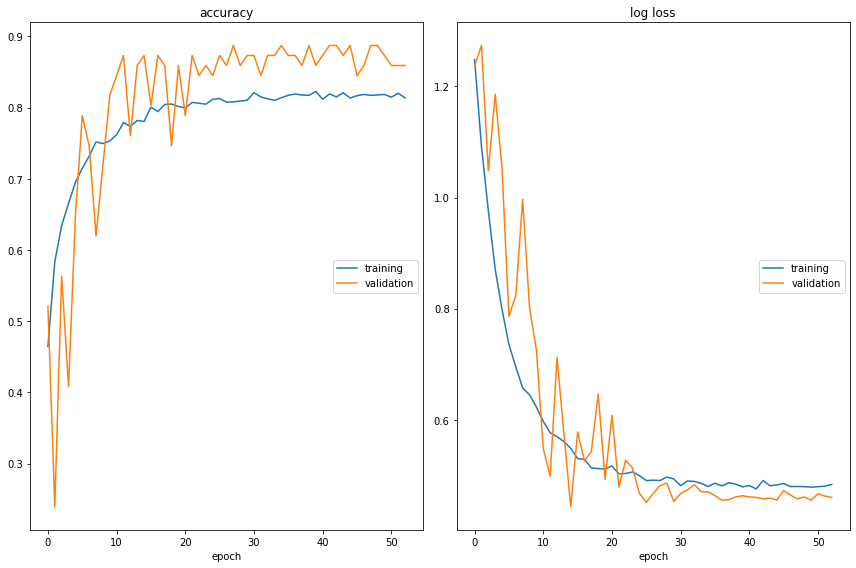

accuracy
	training         	 (min:    0.465, max:    0.823, cur:    0.814)
	validation       	 (min:    0.239, max:    0.887, cur:    0.859)
log loss
	training         	 (min:    0.476, max:    1.248, cur:    0.484)
	validation       	 (min:    0.444, max:    1.274, cur:    0.460)

Tiempo total de entrenamiento: 3180.2425 [s]


In [58]:
# Entrenar el modelo "x"
curves = train_model(
    model = model,
    model_path="model_x",
    train_dataset = train_dataset,
    val_dataset = val_dataset,
    epochs=120,
    criterion=criterion,
    optimizer=optimizer,
    batch_size=128,
    n_evaluations_per_epoch=1,
    device = "cuda",
    data_augmentation=False,
    early_stopping=25,
    scheduler=scheduler
)

## Inferencia sobre el conjunto de test

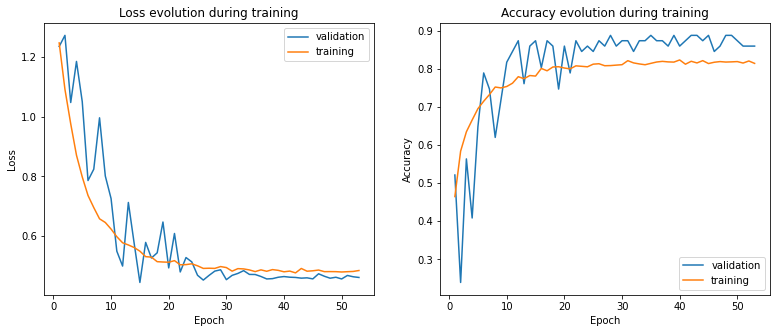

--- Final metrics ---

Final accuracy: 0.8873239436619719
Final loss: 1.2736015319824219

--- Summary ---

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 240, 320]             224
              ReLU-2          [-1, 8, 240, 320]               0
         MaxPool2d-3          [-1, 8, 120, 160]               0
       BatchNorm2d-4          [-1, 8, 120, 160]              16
            Conv2d-5         [-1, 16, 120, 160]           1,168
              ReLU-6         [-1, 16, 120, 160]               0
         MaxPool2d-7           [-1, 16, 60, 80]               0
       BatchNorm2d-8           [-1, 16, 60, 80]              32
            Conv2d-9           [-1, 32, 60, 80]           4,640
             ReLU-10           [-1, 32, 60, 80]               0
        MaxPool2d-11           [-1, 32, 30, 40]               0
      BatchNorm2d-12           [-1, 32, 30, 40]             

In [109]:
model_out = visualize_model("model_x", val_dataset, detail = True)

In [106]:
evaluate_model(model_out, "model_x", test_dataset, criterion= nn.CrossEntropyLoss())

Test loss: 1.2629447985302125, Test acc: 0.6055488540410132


# Descripción del trabajo realizado

### Análisis de los datos de entrenamiento
Se cargan los datos de entrenamiento y se realiza un análisis exploratorio de los datos.

Las imágenes tienen un tamaño de 240x320 pixeles y están en formato RGB. Las imágenes están etiquetadas según carpeta con el nombre de la clase a la que pertenecen. Las clases son: Eosinophil, Lymphocyte, Monocyte, Neutrophil.
 

Luego se crea una clase para cargar los datos de cada conjunto de datos (entrenamiento, validación y test).

Se realiza una función para visualizar la data de cada clase: 
- Obteniendo la cantidad de imágenes por clase.
- Una muestra de las imágenes de cada clase.
- Los histogramas de cada canal de color.
- La distribución de las clases para cada conjunto de datos.
- Un esquema de detección simple del objeto a clasificar.


### Justificación de la elección de hiperparámetros, transformaciones y arquitectura del modelo

Clases previmante balanceadas: Se puede observar que las clases están balanceadas, por lo que no es necesario realizar un balanceo de clases. Sumado a esto, se puede ver que ya fueron preprocedas mediante rotaciones, por lo que a priori no se realizarán transformaciones adicionales de tipo data augmentation.

Problema de normalización de valores en la imagen:  Los valores de los pixeles de las imágenes están en el rango [0,255]. Para poder entrenar la red neuronal, es necesario normalizar los valores de los pixeles a un rango [0,1]. Para esto, se divide cada valor de los pixeles por 255. Así, se puede aprovechar la propiedad de la función de activación ReLU, donde los valores negativos se convierten en 0 y se mantienen cercanos a 0 los valores cercanos positivos, todo con el fin de evitar el problema de la saturación y mayor capacidad de aprendizaje de la red.

Uso de función de activación ReLU: Se utiliza la función de activación ReLU, ya que es una función lineal para valores positivos y 0 para valores negativos que evita en parte el problema de la saturación de la función sigmoide. Además, es computacionalmente más eficiente que la función sigmoide, para obtener mejores resultados, se utilizó la inicialización de los pesos de la red con la distribución normal de Kaiming He, acorde a la función de activación ReLU.

Cantidad y forma de capas convolucionales y variantes de filtros usadas:
- Capas convolucionales pequeñas, para evitar el overfitting en primera instancia, y de dimensiones potencias de dos (8,16,32) para aumentar la eficiencia de la gpu al realizar los cálculos.
- Capas de max-pooling, para reducir la dimensionalidad de la imagen y aumentar la capacidad de generalización de la red.
- Average pooling, ya que es más eficiente computacionalmente que realizar redes MLP para la clasificación de las imágenes.
- Batch normalization, para normalizar los valores de los pixeles de las imágenes y evitar el problema de la saturación de la función de activación ReLU.
- Kernel de 3x3, ya que es el más utilizado en la literatura y es el que mejor resultados ha dado en la práctica, ya que stackear capas de convolución con kernels de 3x3 es equivalente a una capa de convolución con kernel de 5x5, pero con menos parámetros (mantiene el campo receptivo de la imagen).

Otras formas de evitar el overfitting y mejorar el desempeño en general: 
- Se utilizó dropout para evitar el overfitting, ya que es una forma de regularización que consiste en eliminar aleatoriamente una fracción de las neuronas de la capa anterior en cada iteración del entrenamiento. Esto permite que la red aprenda de forma más robusta y generalizada, por defecto se utiliza un dropout de 0.5.
- Se utilizó weight decay en el optimizador para limitar los pesos de la red, lo que evita que los pesos se vuelvan muy grandes y que la red se sobreajuste a los datos de entrenamiento.
- Se utilizó early stopping, ya que es una forma de regularización que consiste en detener el entrenamiento cuando la red deja de mejorar en el conjunto de validación.
- Se utilizó gradiente clipping para evitar que los gradientes exploten, lo que puede provocar que la red no converja.

Clasificación:
- Se utilizó una capa del tamaño del average pooling, para calzar con la dimensionalidad de la imagen y luego una capa intermedia para calzar con la cantidad de clases, donde se utiliza la función de pérdida cross-entropy, ya que es la más utilizada en la literatura para problemas de clasificación multiclase.

Optimizador:
- AdamW, ya que es un optimizador adaptativo que utiliza el gradiente de la función de pérdida para actualizar los pesos de la red, lo que permite que la red converja más rápido y con menos épocas de entrenamiento, donde la W indica que se utiliza weight decay para evitar el overfitting.

Hiperparámetros:
- Se utilizó un learning rate de 0.001, ya que es un valor utilizado frecuentemente con el modelo de learning rate adaptativo de Adam, permitiendo que parta en un valor relativamente alto y luego se vaya reduciendo a medida que la red converja.
- 
-

### Análisis de los resultados


#### Resultados obtenidos:
![](https://drive.google.com/uc?export=view&id=1Mnx2rKGewgY6qAlG1bDfr9zXQYEFZF9B)

Usando batch_size = 128.
Usando batch_seize = 64

- problemas que encontramos 
- algunas metodologías que intentamos y no funcionaron
- algunas metodologías que intentamos y sí funcionaron